# Dative Sickness

This jupyter notebook contains all the information necessary to replicate the study in *Dative Sickness: A Phylogenetic Analysis of Argument Structure Evolution in Germanic*. The notebook and supporting files are available as a repository on GitHub: https://github.com/evoling/dative-sickness. A static (read-only, non-interactive) version can be found at http://evoling.github.io/dative-sickness/.

## 0. Setup

Before we start, check that necessary tools are present, and that we can find all the necessary data files. Click on the box below to select it and press the **Run Cell** button (the rightward-facing triangle). The selection automatically progresses to the next cell, so you can work through the notebook by pressing **Run Cell** repeatedly.

In [1]:
# Is BayesTraits installed?
from subprocess import check_output
from hashlib import md5
import rpy2
# this will raise a CalledProcessError if BayesTraits isn't installed and on the path
path = check_output(["which", "BayesTraits"]).strip()
# document which version of the binary we are using
print("Binary version (md5 hash):", md5(open(path, "rb").read()).hexdigest())

Binary version (md5 hash): 675e37408c8de2d93a6f988a1d912b6d


This notebook is written in [`python`](https://www.python.org/) version 3, and requires the `jupyter` and `rpy2` libraries and their dependencies, which can be installed using the command `pip install jupyter rpy2`. The `rpy2` library is a bridge to the [R statistical language](https://www.r-project.org/), which should also be installed, along with the R library `ape` (installed within R using `install.packages("ape")`). The workflow assumes a unix-like system, such as MacOSX or Linux.

In [2]:
# Are the data files present
from os.path import exists
DATAFILE = "data/GmcArgStrucStates.csv"
assert exists(DATAFILE)
TREEFILE = "data/germanic-tree.tre"
assert exists(TREEFILE)

In [3]:
# Setup for using R through python
%load_ext rpy2.ipython
%Rpush TREEFILE

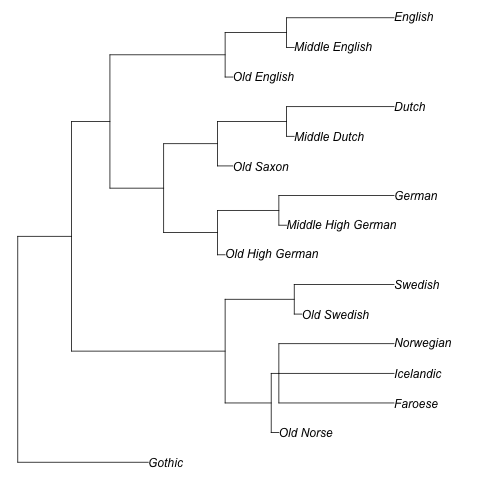

In [4]:
%%R
# Check the reference tree
library("ape")
plot(read.nexus(TREEFILE), no.margin=TRUE)

## 1. MULTISTATE test: All Models

This test runs a multistate analysis of every possible model of evolution, defined by constraining a subset of the transition probabilities to zero. The unconstrained model (i.e. the model which estimates all transitions) is:

  | A | N | D
--|---|---|---
A |   |qAN|qAD
N |qNA|   |qND
D |qDA|qDN|

The *Dative sickness* model is defined as:

  | A | N | D
--|---|---|---
A |   |qAN|qAD
N | 0 |   | 0
D | 0 |qDN|

The following snippet creates BayesTraits command files for all possible models, as well a shell script RUNFILE to run them. This produces a MULTISTATE analysis using Maximum Likelihood. Testing showed that 1000 repeats of the ML test ensures a stable response.

In [5]:
from itertools import chain, combinations
RUNFILE = "build/runfile.sh"

transitions = ["q"+i+j for i in "ADN" for j in "ADN" if i != j]

def all_subsets(ss):
    return chain([None], *map(lambda x: combinations(ss, x), range(1, len(ss))))

with open(RUNFILE, "w") as runfile:
    for i, subset in enumerate(all_subsets(transitions)):
        filename = "build/job{:02d}.cmd".format(i)
        print("BayesTraits", TREEFILE, DATAFILE, "<", filename, "> /dev/null",
                file=runfile)
        with open(filename, "w") as fo:
            print("1", file=fo) # MULTISTATE analysis type
            print("1", file=fo) # Maximum likelihood
            print("logfile build/job{:02d}.log".format(i), file=fo)
            print("mltries 1000", file=fo) # Run ML 1000x to ensure a stable response
            if subset: # else unconstrained model
                subset += ("0",)
                print("restrict", *subset, file=fo)
            print("run", file=fo)
    print("echo All log files are complete!", file=runfile)


*The next command could take a few minutes. Do not continue further until all the log files are complete.*
Note that the prompt will have a star instead of a number while a script is still processing, like this: `In [*]`

In [6]:
%%script bash
sh ./build/runfile.sh

>78All log files are complete!


###### Summarise models

In [7]:
from glob import glob
from io import StringIO
from IPython.display import HTML

header = ["Tree No", "Lh", "qAD", "qAN", "qDA", "qDN", "qNA", "qND",
        "Root - S(0) - P(A)", "Root - S(0) - P(D)", "Root - S(0) - P(N)",
        "Root - S(1) - P(A)", "Root - S(1) - P(D)", "Root - S(1) - P(N)",
        "Root - S(2) - P(A)", "Root - S(2) - P(D)", "Root - S(2) - P(N)",
        "Root - S(3) - P(A)", "Root - S(3) - P(D)", "Root - S(3) - P(N)",
        "Root - S(4) - P(A)", "Root - S(4) - P(D)", "Root - S(4) - P(N)",
        "Root - S(5) - P(A)", "Root - S(5) - P(D)", "Root - S(5) - P(N)",
        "Root - S(6) - P(A)", "Root - S(6) - P(D)", "Root - S(6) - P(N)",
        "Root - S(7) - P(A)", "Root - S(7) - P(D)", "Root - S(7) - P(N)",
        "Root - S(8) - P(A)", "Root - S(8) - P(D)", "Root - S(8) - P(N)",
        "Root - S(9) - P(A)", "Root - S(9) - P(D)", "Root - S(9) - P(N)",
        "Root - S(10) - P(A)", "Root - S(10) - P(D)", "Root - S(10) - P(N)",
        "Root - S(11) - P(A)", "Root - S(11) - P(D)", "Root - S(11) - P(N)"]

data = {}

for filename in glob("build/*.log"):
    restriction0 = set()
    with open(filename) as fileobj:
        for line in fileobj:
            if line.startswith("Restrictions"):
                break
        # parse restrictions
        counter = 0
        for line in fileobj:
            counter += 1
            row = line.strip().split()
            try:
                float(row[1])
                restriction0.add(row[0])
            except ValueError:
                pass
            if counter == 6:
                break
        model = "=".join(sorted(restriction0)+["0"])
        for line in fileobj:
            pass
    # parse final line
    row = [float(e) for e in line.strip().split()]
    row_data = {}
    for key, value in zip(header, row):
        if key.startswith("q") or key == "Lh":
            row_data[key] = value
        elif key.startswith("Root"):
            lexeme_key = key.split()[2]
            state_key = key.split()[-1]
            row_data.setdefault(lexeme_key, {})[state_key] = value
    if model == "0":
        Lh_unconstrained = row_data["Lh"]
    data[model] = row_data

lexemes = ["hunger", "thirst", "like", "lack", "dream", "avail/suffice",
        "lust", "long", "wonder", "think/seem", "suffice/avail", "fail"]
CM_recon = ["A", "A", "D", "A", "A", "D", "A", "A", "A", "D", "D", "A"]
    
header = (["model", "Lh", "qAD", "qAN", "qDA", "qDN", "qNA", "qND"] +
        ["{} *{}".format(l, r) for l, r in zip(lexemes, CM_recon)] +
        ["mismatch", "Lh_ratio"])

results = StringIO()

print("<table>", file=results)
print("<tr>{}</tr>".format(
        "".join(["<th>{}</th>".format(item) for item in header])),
        file=results)

def get_name(model):
    if model == "qDA=qNA=qND=0":
        return model + " (Dative Sickness)"
    elif model == "qAD=qNA=qND=0":
        return model + " (Accusative Sickness)"
    elif model == "qDA=qDN=qND=0":
        return model + " (Nominative Sickness)"
    elif model == "0":
        return "Unconstrained"
    else:
        return model

rows = []
for model in sorted(data):
    row_data = data[model]
    row = [get_name(model)]
    for key in ["Lh", "qAD", "qAN", "qDA", "qDN", "qNA", "qND"]:
        row.append(row_data[key])
    mismatch = 0
    for i, cm in zip(range(14), CM_recon):
        try:
            d = row_data["S({})".format(i)]
            recon = sorted(d, key=lambda k: d[k])[-1]
            if d[recon] < 0.95:
                recon = "?"
                mismatch += 1
            else:
                recon = recon[-2]
                if recon != cm:
                    mismatch += 1
            row.append(recon)
        except KeyError:
            pass
    row.append(mismatch)
    row.append(2* (Lh_unconstrained - row_data["Lh"]))
    rows.append(row)
    
for row in sorted(rows, key=lambda e: (e[0]!="Unconstrained", -e[1])):
    print("<tr>{}</tr>".format(
            "".join(["<td>{}</td>".format(item) for item in row])),
            file=results)
print("</table>", file=results)

results.seek(0)
HTML(results.read())

model,Lh,qAD,qAN,qDA,qDN,qNA,qND,hunger *A,thirst *A,like *D,lack *A,dream *A,avail/suffice *D,lust *A,long *A,wonder *A,think/seem *D,suffice/avail *D,fail *A,mismatch,Lh_ratio
Unconstrained,-105.563723,0.0,1.397095,0.0,0.000483,1.392374,0.000188,?,?,D,?,?,?,?,?,?,D,D,?,9,0.0
qDA=0,-101.484659,0.000126,0.000931,0.0,0.000439,0.001253,5.1e-05,?,?,D,?,?,?,?,?,?,D,D,?,9,-8.158128000000005
qDA=qND=0,-101.490133,0.00015,0.000922,0.0,0.000434,0.001285,0.0,?,?,D,?,?,?,?,?,?,D,D,?,9,-8.147179999999992
qAD=qDA=0,-101.580879,0.0,0.001011,0.0,0.000472,0.001133,0.000331,?,?,?,?,?,?,?,?,?,D,?,?,11,-7.965688
qAD=0,-105.044298,0.0,0.036236,0.0,0.000467,0.044167,0.000191,?,?,D,?,?,?,?,?,?,D,D,?,9,-1.0388499999999965
qND=0,-105.0882,0.000152,0.100965,6e-06,0.000459,0.12176,0.0,?,?,D,?,?,?,?,?,?,D,D,?,9,-0.951045999999991
qAD=qDN=0,-105.11764,0.0,0.470991,0.000463,0.0,0.563012,0.000179,?,?,D,?,?,?,?,?,?,D,D,?,9,-0.8921660000000031
qDN=qND=0,-105.12201,0.000149,0.219155,0.000465,0.0,0.26543,0.0,?,?,D,?,?,?,?,?,?,D,D,?,9,-0.8834259999999858
qDN=0,-105.135701,0.000148,0.091739,0.000464,0.0,0.110664,0.0,?,?,D,?,?,?,?,?,?,D,D,?,9,-0.8560439999999971
qAD=qNA=0,-106.57183,0.0,0.000628,9e-05,0.000597,0.0,0.001045,A,A,?,?,?,?,A,A,?,?,?,A,7,2.0162140000000193


###### Make Pie Data

This snippet creates two data files containing ancestral state reconstruction probabilities for the Unconstrained and Dative sickness models

In [8]:
from __future__ import print_function

template = 'Root - S({N}) - P({state})'

for filein, fileout in [
        ("build/job00.log", "build/asr-unconstrained.csv"),
        ("build/job40.log", "build/asr-dative-sickness.csv")]:
    with open(filein) as logfile:
        with open(fileout, "w") as outfile:
            lines = logfile.readlines()
            keys = lines[-2].strip().split("\t")
            values = map(float, lines[-1].strip().split("\t"))
            data = dict(zip(keys, values))
            for N in range(12):
                row = [lexemes[N]]
                for state in "ADN":
                    key = template.format(N=N, state=state)
                    row.append(data[key])
                    if state == CM_recon[N]:
                        if data[key] > 0.95:
                            row[0] += "*"
                print(*row, sep="\t", file=outfile)

###### Plot pies

Plot the data from the files generated above.

In [9]:
%%R
# library(RColorBrewer)
# colours <- brewer.pal(3, "Dark2")
colours <- c("#1B9E77", "#D95F02", "#7570B3")

png("build/asr-unconstrained.png", width=400, height=300)
d <- read.delim("build/asr-unconstrained.csv", row.names=1, header=FALSE)
par(mfrow=c(3,4), mar=c(0,0,1,0))
for (i in 1:12) 
  pie(unlist(d[i,]), labels=NA, col=colours,
    main=row.names(d)[i], cex.main=2)
. <- dev.off()

png("build/asr-dative-sickness.png", width=400, height=300)
d <- read.delim("build/asr-dative-sickness.csv", row.names=1, header=FALSE)
par(mfrow=c(3,4), mar=c(0,0,1,0))
for (i in 1:12) 
  pie(unlist(d[i,]), labels=NA, col=colours,
    main=row.names(d)[i], cex.main=2)
. <- dev.off()

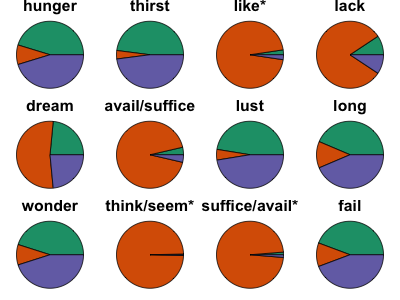

In [10]:
from IPython.display import Image
Image(filename="build/asr-unconstrained.png")

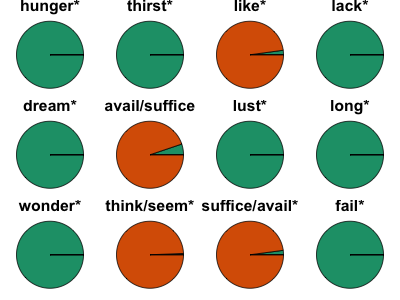

In [11]:
Image(filename="build/asr-dative-sickness.png")